# Benchmark GSEA speed

Compare speed of GSEApy, fGSEA, and blitzGSEA. The runtime of fGSEA is calculated in a separate notebook as it runs in an R environment.

In [117]:
%%capture
!pip3 install git+https://github.com/MaayanLab/blitzgsea.git

In [118]:
import importlib

import blitzgsea as blitz
importlib.reload(blitz)

import gseapy

import prismx as pxx
import prismx as px
importlib.reload(px)

import time
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
signature = pd.read_csv("ageing_muscle_gtex.tsv")
library = blitz.enrichr.get_library("GO_Biological_Process_2021")

## blitzGSEA benchmark

Calculate runtime for 6000 gene sets for different number of threads with signature cache turned off. The signature cache would avoid recalculating anchor parameters. Run blitzGSEA with signature cache activated ones. Only the probabilies will be caluclated. This step does not benefit from multi-threading as it is memory constraint.

In [124]:
tt = []
for i in range(1,8):
    print(i)
    st = time.time()
    blitz.gsea(signature, library, processes=i, permutations=1000, min_size=5, max_size=4000, signature_cache=False)
    tt.append(time.time()-st)

print(tt)

st = time.time()
blitz.gsea(signature, library, processes=1, permutations=1000, min_size=5, max_size=4000)
sigcache = time.time()-st

1


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1378.80it/s]


2


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1390.41it/s]


3


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1398.84it/s]


4


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1405.68it/s]


5


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1404.65it/s]


6


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1426.86it/s]


7


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1412.08it/s]


[21.36675262451172, 14.334275007247925, 11.435843229293823, 10.072898626327515, 9.450721979141235, 9.389051675796509, 9.029001951217651]
Use cached anchor parameters


Enrichment : 100%|██████████| 6036/6036 [00:04<00:00, 1413.69it/s]


In [10]:
sigh = [sigcache]*len(tt)

## Compute GSEApy runtime

Library needs to be chunked due to very high memory requirements. Chunking does not slow down the algorithm significanltly.

In [ ]:
permutation_num = 1000
max_lib_size = 100
outdir='test/prerank_report_kegg'
format='png'
seed=1
processes= 3

gpy = []

sig = signature.sort_values(1, ascending=False)
sig = signature[~signature.index.duplicated(keep='first')]

def chopped_gsea(rnk, gene_sets, processes, permutation_num=1000, max_lib_size=50, outdir='test/prerank_report_kegg', format='png', seed=1):
    library_keys = list(gene_sets.keys())
    chunks = [library_keys[i:i+max_lib_size] for i in range(0, len(library_keys), max_lib_size)]
    results = []
    for chunk in chunks:
        tlib = {}
        for k in chunk:
            tlib[k] = gene_sets[k]
        pre_res = gseapy.prerank(rnk=rnk, gene_sets=tlib, processes=processes, permutation_num=permutation_num, outdir=outdir, format=format, seed=seed)
        results.append(pre_res.res2d)
    return pd.concat(results)

tt_gseapy = []
for p in range(1,9):
    st = time.time()
    res2 = chopped_gsea(sig, library, p, permutation_num=permutation_num, max_lib_size=50)
    et2 = time.time() - st
    tt_gseapy.append(et2)

## Plot results

Plot the results for GSEApy, fGSEA, and blitzGSEA. Speed for GSEApy and fGSEA was precomputed. fGSEA does not support multi-threading and the average runtime is plotted as a constant.

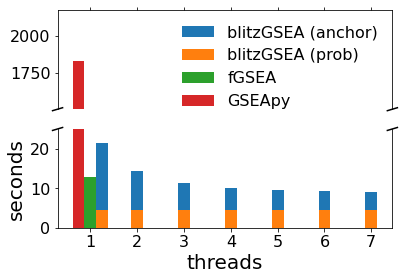

In [152]:
width = 0.5
labels = range(1,len(tt)+1)
fgsea = [12.7578]*len(tt)
x = np.array(range(1,len(tt)+1))*2
xt = np.array(x)
xt[0] = 3

tt_gseapy = tt_gseapy[0:len(tt)]

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

rects1 = ax.bar(xt-0.25, tt, width, label='blitzGSEA (anchor)')
rects2 = ax.bar(xt-0.25, sigh, width, label='blitzGSEA (prob)')
rects3 = ax.bar(2, 12.7578, width, label='fGSEA')
rects4 = ax.bar(2-0.5, 1830.63, width, label='GSEApy')
#rects5 = ax.bar(xt+0.25, tt_gseapy, width, label='GSEApy')

rects1 = ax2.bar(xt-[0.5,0,0,0,0,0,0], tt, width, label='blitzGSEA (anchor)')
rects2 = ax2.bar(xt-[0.5,0,0,0,0,0,0], sigh, width, label='blitzGSEA (prob)')
rects3 = ax2.bar(2, 12.7578, width, label='fGSEA')
rects4 = ax2.bar(2-0.5, 200, width, label='GSEApy')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax.tick_params(labelsize=16)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set_ylim(min(tt_gseapy)-50, max(tt_gseapy)+50)  # outliers only
ax2.set_ylim(0, 25)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax2.set_ylabel('seconds', fontsize=20)
ax2.set_xlabel('threads', fontsize=20)
plt.tick_params(labelsize=16)
ax.legend(fontsize=16, frameon=False)

plt.savefig("figures/speed_threads_fgsea.pdf", bbox_inches='tight')